In [1]:
import sys
import pandas as pd
import numpy as np

# Define a random seed for reproducibility
seed = 0
np.random.seed(seed)

import sklearn
import xgboost
import keras
import tensorflow as tf

import os
import pickle
import matplotlib.pyplot as plt


print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('XGBoost: {}'.format(xgboost.__version__))
print('Keras: {}'.format(keras.__version__))

Using TensorFlow backend.


Python: 3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.0.3
Numpy: 1.18.1
Sklearn: 0.22.1
XGBoost: 1.1.1
Keras: 2.3.1


In [2]:
def load_train_and_test(path):

    """Loads training features, training labels, testing features, and testing features
    Parameters:
        path (str) -- a single directory path containing all four datasets
    """

    train_features = pd.read_csv(path + 'train_features.csv', index_col=0)
    train_labels = pd.read_csv(path + 'train_labels.csv', index_col=0)
    test_features = pd.read_csv(path + 'test_features.csv', index_col=0)
    test_labels = pd.read_csv(path + 'test_labels.csv', index_col=0)

    return train_features, train_labels.values.ravel(), test_features, test_labels.values.ravel()

X_train, Y_train, X_test, Y_test = load_train_and_test('../data/split/')

In [3]:
# load all optimized models from the models folder

dirName = '../models/'

fileList = list()
dirList = list()

for (dirpath, dirnames, filenames) in os. walk(dirName):
    for file in filenames:
        if '.sav' in file:
            fileList.append(os.path. join(dirpath, file))

modelList = list()

for file in fileList:
    model = pickle.load(open(file, 'rb'))
    modelList.append(model)

In [4]:
def bootstrap_roc_curves(model, X_test, Y_test):
    # predict probabilities
    lr_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = [round(x,2) for x in lr_probs[:, 1]]
    
    n_bootstraps = 1000
    rng_seed = 42# control reproducibility
    bootstrapped_scores = []
    fprList = []
    tprList = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(lr_probs), len(lr_probs))
        if len(np.unique(np.array(Y_test)[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        labels = np.array(Y_test)[indices]
        predictions = np.array(lr_probs)[indices]

        # calculate scores and curve
        bootstrapped_scores.append(sklearn.metrics.roc_auc_score(labels, predictions))
        lr_fpr, lr_tpr, _ = sklearn.metrics.roc_curve(labels, predictions, drop_intermediate=True)
        
        fprList.append(lr_fpr)
        tprList.append(lr_tpr)
    
    return fprList, tprList, bootstrapped_scores

In [7]:
import matplotlib.pyplot as plt

def generate_roc_curves(models, names, X_test, Y_test, bootstrap=True):
    
    plt.figure(figsize=(10,10))
    cmap = plt.get_cmap('tab10')
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(Y_test))]
    
    for i,model in enumerate(models):
        
        # predict probabilities
        lr_probs = model.predict_proba(X_test)
        
        # keep probabilities for the positive outcome only
        lr_probs = lr_probs[:, 1]
        
        # calculate scores and curve
        lr_auc = sklearn.metrics.roc_auc_score(Y_test, lr_probs)
        lr_fpr, lr_tpr, _ = sklearn.metrics.roc_curve(Y_test, lr_probs)
        
        if bootstrap:
            fpr, tpr, scores = bootstrap_roc_curves(model, X_test, Y_test)
            
            scores.sort()
            sorted = np.array(scores)
        
        # plot the roc curve for the model
        plt.plot(lr_fpr, lr_tpr, color=cmap(0.1*i), marker='', label='{} (AUC = {} (95% CI {} to {}))'.format(names[i], round(lr_auc,3), round(sorted[25], 3), round(sorted[975],3)))
    
    # plot the roc curve for the no skill model
    ns_fpr, ns_tpr, _ = sklearn.metrics.roc_curve(Y_test, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', color='black', label='No Skill (AUC = 0.500)')
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # title
    plt.title('ROC AUC Scores by Algorithm Type')
    # show the legend
    plt.legend(loc = 'lower right')
    # show the plot
    plt.show()
    
    plt.savefig('../reports/figures/ROC_AUC_comparison.png')
    
    return None

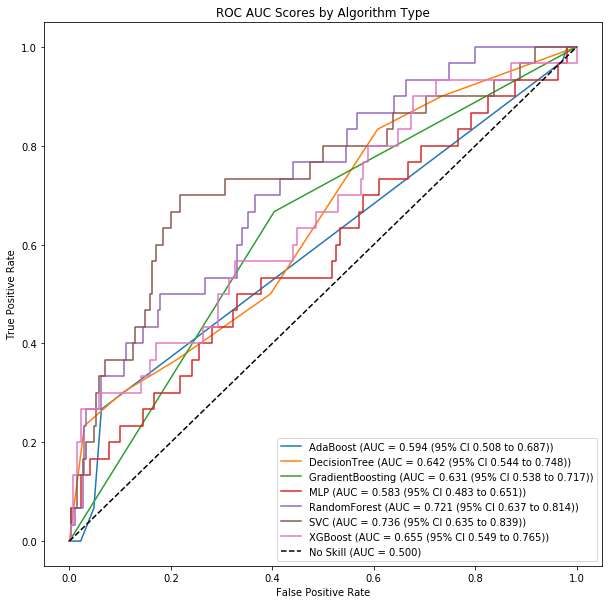

<Figure size 432x288 with 0 Axes>

In [8]:
index = [file.split('/')[-1].rstrip('.sav') for file in fileList]
generate_roc_curves(modelList, index, X_test, Y_test)

In [9]:
from sklearn.metrics import classification_report

def scores(Y_test, y_pred):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(Y_test, y_pred).ravel()
    print('{}, {}, {}, {}\n'.format(tn, fp, fn, tp))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    PPV = tp / (tp + fp)
    NPV = tn / (tn + fn)

    print('Sensitivity: {}'.format(sensitivity))
    print('Specificity: {}'.format(specificity))
    print('PPV: {}'.format(PPV))
    print('NPV: {}'.format(NPV))

    return None

curves = []

for model in modelList:
    y_pred = model.predict(X_test)
    print(model)
    print(classification_report(Y_test, y_pred))
    scores(Y_test, y_pred)
    curves.append(sklearn.metrics.roc_curve(Y_test, y_pred))
    print('\n')

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=1.9553972700565248, n_estimators=16,
                   random_state=0)
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       270
           1       0.13      0.07      0.09        30

    accuracy                           0.86       300
   macro avg       0.52      0.51      0.51       300
weighted avg       0.82      0.86      0.84       300

257, 13, 28, 2

Sensitivity: 0.06666666666666667
Specificity: 0.9518518518518518
PPV: 0.13333333333333333
NPV: 0.9017543859649123


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.00017372854537759253,
                       min_impurity_split=None, min_samples_leaf=9,
                       min_samples_split=4,
                       min_weigh